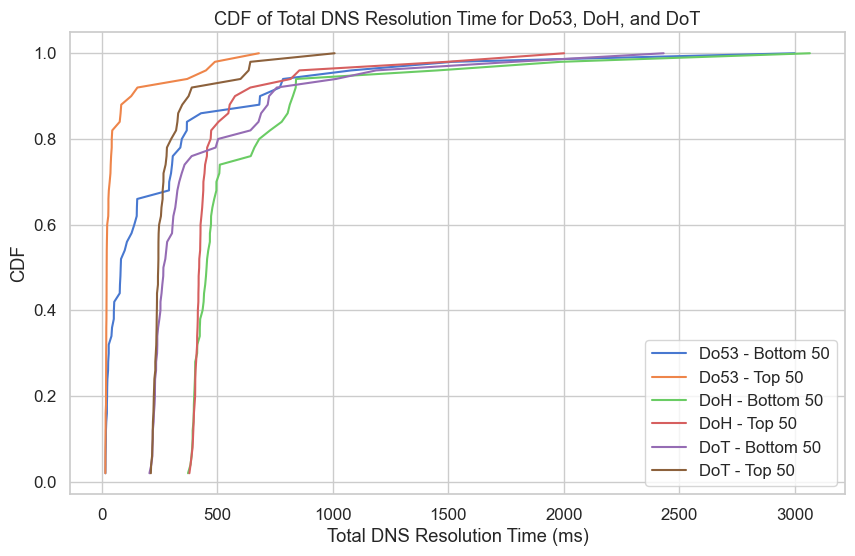

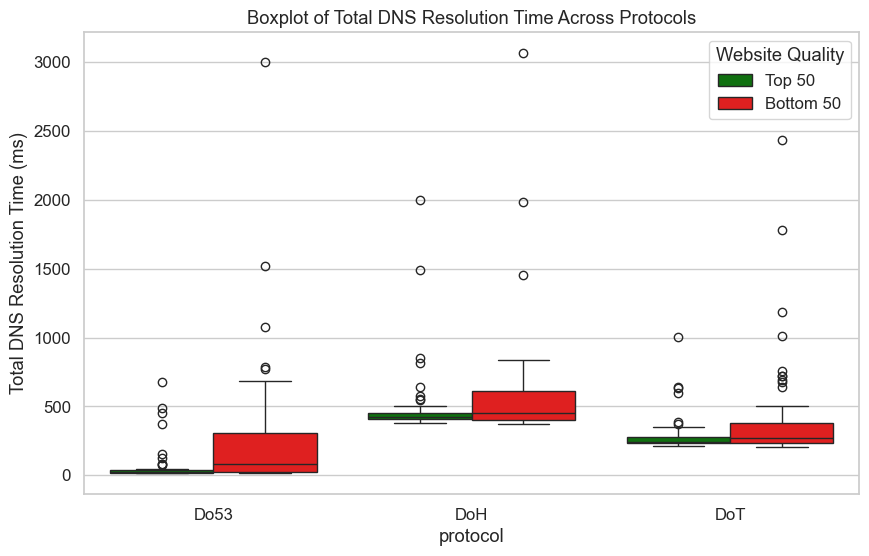

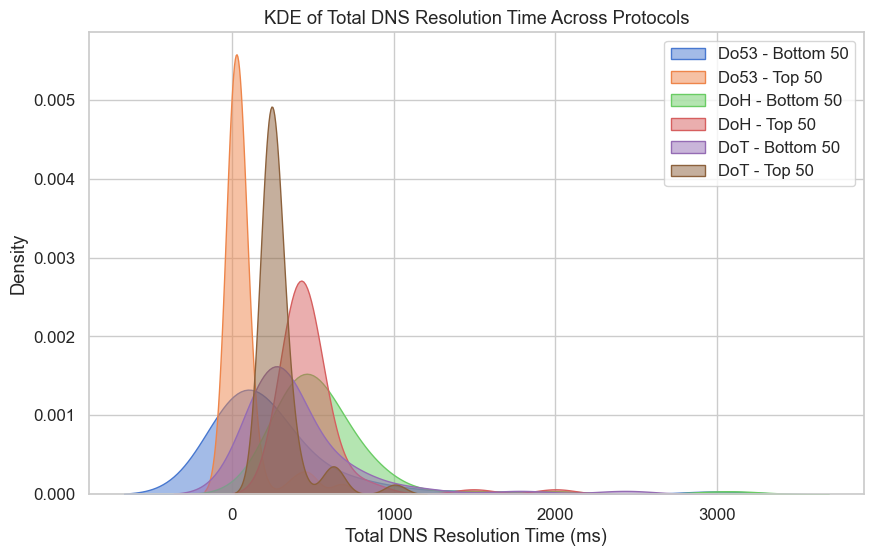

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- File paths ----------
path_do53_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/Do53/dns_cf_do53_top.csv"
path_do53_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/Do53/dns_cf_do53_bot50d.csv"

path_doh_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoH/dns_google_dot_top50.csv"
path_doh_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoH/dns_google_dot_bot50.csv"

path_dot_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoT/dns_google_dot_top50.csv"
path_dot_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoT/dns_google_dot_bot50.csv"

# ---------- Load CSVs ----------
df_do53_top = pd.read_csv(path_do53_top)
df_do53_bottom = pd.read_csv(path_do53_bottom)
df_doh_top = pd.read_csv(path_doh_top)
df_doh_bottom = pd.read_csv(path_doh_bottom)
df_dot_top = pd.read_csv(path_dot_top)
df_dot_bottom = pd.read_csv(path_dot_bottom)

# ---------- Compute total_ms ----------
df_do53_top['total_ms'] = df_do53_top['rtt_ms']
df_do53_bottom['total_ms'] = df_do53_bottom['rtt_ms']

df_doh_top['total_ms'] = df_doh_top['tcp_connect_ms'] + df_doh_top['tls_handshake_ms'] + df_doh_top['query_rtt_ms']
df_doh_bottom['total_ms'] = df_doh_bottom['tcp_connect_ms'] + df_doh_bottom['tls_handshake_ms'] + df_doh_bottom['query_rtt_ms']

df_dot_top['total_ms'] = df_dot_top['tcp_connect_ms'] + df_dot_top['tls_handshake_ms'] + df_dot_top['query_rtt_ms']
df_dot_bottom['total_ms'] = df_dot_bottom['tcp_connect_ms'] + df_dot_bottom['tls_handshake_ms'] + df_dot_bottom['query_rtt_ms']

# ---------- Combine all for plotting ----------
def label_df(df, protocol, quality):
    df = df.copy()
    df['protocol'] = protocol
    df['quality'] = quality
    return df[['total_ms','protocol','quality']]

df_all = pd.concat([
    label_df(df_do53_top, "Do53", "Top 50"),
    label_df(df_do53_bottom, "Do53", "Bottom 50"),
    label_df(df_doh_top, "DoH", "Top 50"),
    label_df(df_doh_bottom, "DoH", "Bottom 50"),
    label_df(df_dot_top, "DoT", "Top 50"),
    label_df(df_dot_bottom, "DoT", "Bottom 50")
])

# ---------- Set seaborn style ----------
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# ---------- 1️⃣ CDF of total time ----------
plt.figure(figsize=(10,6))
for (protocol, quality), group in df_all.groupby(['protocol','quality']):
    sorted_data = np.sort(group['total_ms'])
    yvals = np.arange(1, len(sorted_data)+1)/len(sorted_data)
    plt.plot(sorted_data, yvals, label=f"{protocol} - {quality}")

plt.xlabel("Total DNS Resolution Time (ms)")
plt.ylabel("CDF")
plt.title("CDF of Total DNS Resolution Time for Do53, DoH, and DoT")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 2️⃣ Boxplot of total time ----------
plt.figure(figsize=(10,6))
sns.boxplot(x='protocol', y='total_ms', hue='quality', data=df_all, palette=["green","red"])
plt.ylabel("Total DNS Resolution Time (ms)")
plt.title("Boxplot of Total DNS Resolution Time Across Protocols")
plt.legend(title="Website Quality")
plt.show()

# ---------- 3️⃣ KDE of total time ----------
plt.figure(figsize=(10,6))
for (protocol, quality), group in df_all.groupby(['protocol','quality']):
    sns.kdeplot(group['total_ms'], fill=True, alpha=0.5, label=f"{protocol} - {quality}")
plt.xlabel("Total DNS Resolution Time (ms)")
plt.ylabel("Density")
plt.title("KDE of Total DNS Resolution Time Across Protocols")
plt.legend()
plt.show()

In [3]:
import pandas as pd

# ---------- File paths ----------
path_do53_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/Do53/dns_cf_do53_top.csv"
path_do53_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/Do53/dns_cf_do53_bot50d.csv"

path_doh_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoH/dns_google_dot_top50.csv"
path_doh_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoH/dns_google_dot_bot50.csv"

path_dot_top = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoT/dns_google_dot_top50.csv"
path_dot_bottom = "/Users/tejasmacipad/Desktop/final_CN_project/CN_Project/Report/DoT/dns_google_dot_bot50.csv"

# ---------- Load CSVs ----------
dfs = {
    "Do53 - Top50": pd.read_csv(path_do53_top),
    "Do53 - Bottom50": pd.read_csv(path_do53_bottom),
    "DoH - Top50": pd.read_csv(path_doh_top),
    "DoH - Bottom50": pd.read_csv(path_doh_bottom),
    "DoT - Top50": pd.read_csv(path_dot_top),
    "DoT - Bottom50": pd.read_csv(path_dot_bottom)
}

# ---------- Function to compute total time ----------
def compute_total_time(df, protocol_type):
    df = df.copy()
    if protocol_type == "Do53":
        df['total_ms'] = df['rtt_ms']
    else:  # DoH or DoT
        df['total_ms'] = df['tcp_connect_ms'] + df['tls_handshake_ms'] + df['query_rtt_ms']
    return df

# ---------- Prepare summary ----------
summary = []

for key, df in dfs.items():
    protocol, quality = key.split(" - ")
    df = compute_total_time(df, protocol)
    
    # Only consider successful queries
    df_success = df[df['status'] == "SUCCESS"]
    
    avg_total = df_success['total_ms'].mean()
    num_success = len(df_success)
    
    summary.append({
        "Protocol": protocol,
        "Website Quality": quality,
        "Average Total Time (ms)": round(avg_total, 3),
        "Number of Successful Queries": num_success
    })

# ---------- Convert to DataFrame ----------
summary_df = pd.DataFrame(summary)
print(summary_df)

  Protocol Website Quality  Average Total Time (ms)  \
0     Do53           Top50                   69.375   
1     Do53        Bottom50                  220.095   
2      DoH           Top50                  503.616   
3      DoH        Bottom50                  603.894   
4      DoT           Top50                  293.077   
5      DoT        Bottom50                  433.652   

   Number of Successful Queries  
0                            50  
1                            49  
2                            50  
3                            50  
4                            50  
5                            50  
